## Modelado

El modelado de las series temporales nos sirve para realizar predicciones, estimaciones de valores futuros y preparar nuestros procesos en base a estos. Ejemplo: si realizamos la previsión de ventas de producto podemos actualizar el stock de cara a no quedarnos sin existencias.

Para ello deberemos ser capaces de evaluar la bondad de nuestras estimaciones y para ello emplearemos las métricas habituales...

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coeficiente de determinación, $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): error que emplea el mismo nivel de unidad que nuestros datos, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error):algo más robusto a los valores anómalos que el MAE, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): penaliza más los valores altos, muy utilizado, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): con datos que muestran una tendencia exponencial nos permite penalizar valores muy pequeños también, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: equivalente al MAE pero mostrado de forma porcentual, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

Adicionalmente deberemos tener en cuenta ciertos criterios considerados por el modelado en series temporales.

### AIC

Akaike’s Information Criterion

![imagen](./img/aic.png)

$k$ es el número de parámetros del modelo estadístico y $L$ es el máximo valor de la función de verosimilitud para el modelo estimado. La función de verosimilitud permite realizar inferencias a partir de u conjunto de observaciones.

Se utiliza para seleccionar el mejor modelo, que será el que tiene menor AIC. El AIC depende mucho de cada dato, y es una medida de comparación entre modelos, no de presentación de resultados. Un AIC bajo no quiere decir que el modelo sea muy bueno. Por tanto, AIC no nos dice nada sobre la calidad del modelo en términos absolutos.

### BIC

El Criterio de Información Bayesiano (BIC) es un método estadístico para evaluar la calidad relativa de modelos entre un conjunto finito de opciones. Se basa en la función de probabilidad y está estrechamente relacionado con el Criterio de Información de Akaike (AIC).

## Análisis inicial

Vamos a utilizar los datos de ventas de Johnson&Johnson

In [7]:
import pandas as pd

data = pd.read_csv('data/a10.csv', index_col=0, parse_dates=['date'])
print("Tamaño de la serie ", len(data))
data.head()

Tamaño de la serie  204


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


In [8]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable


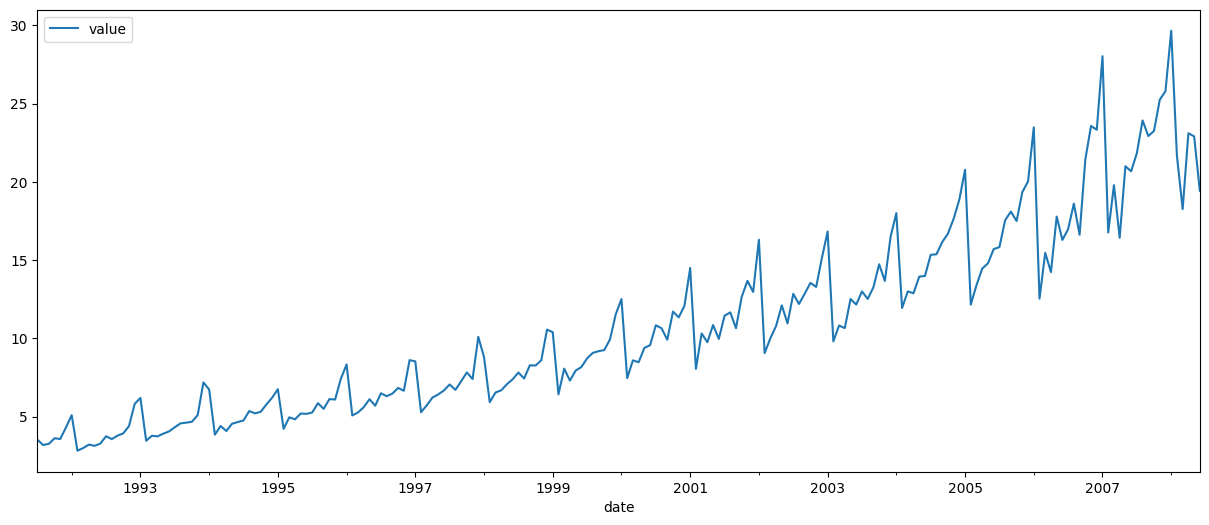

In [9]:
data.plot(figsize=(15,6));

Se aprecia en la gráfica que presenta diferentes estadísticos a lo largo del tiempo. Sabemos que esto va a ser un gran limitante dado que la estacionariedad de la serie es un factor clave a la hora de disponer un buen estimador.

In [10]:
from statsmodels.tsa.stattools import adfuller

stat, pval, usedlag, nobs,crtivals, icbest = adfuller(data.values)
print(pval)

1.0


La hipótesis nula de Dickey-Fuller aumentado es que hay una raíz unitaria, con la alternativa de que no hay raíz unitaria. Si el valor p está por encima de un tamaño crítico, entonces no podemos rechazar que exista una raíz unitaria.

Los p-valores se obtienen mediante la aproximación de superficie de regresión de MacKinnon 1994, pero utilizando las tablas actualizadas de 2010. Si el valor p está cerca de ser significativo, entonces los valores críticos deben utilizarse para juzgar si se rechaza la nulidad. La opción autolag y maxlag para ella se describen en Greene.

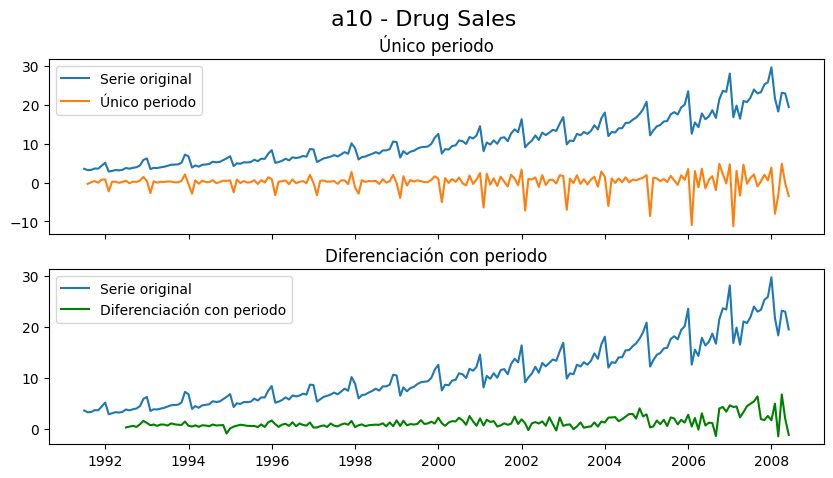

In [11]:
import matplotlib.pyplot as plt

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Diferencia usual
axes[0].plot(data[:], label='Serie original')
axes[0].plot(data[:].diff(1), label='Único periodo')
axes[0].set_title('Único periodo')
axes[0].legend(loc='upper left', fontsize=10)

# Estacionalidad
axes[1].plot(data[:], label='Serie original')
axes[1].plot(data[:].diff(12), label='Diferenciación con periodo', color='green')
axes[1].set_title('Diferenciación con periodo')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('a10 - Drug Sales', fontsize=16)
plt.show()

In [12]:
# Con diferenciación de segundo orden
stat, pval, usedlag, nobs,crtivals, icbest = adfuller(data.diff(12).diff(12).dropna().values)
print(pval)

0.00011730556082591169


# División en train y test

A diferencia de las muestras independientes, en el caso de las series temporales es importante realizar los tests con el último bloque de la serie.

In [13]:
X = data.values
train = X[:150]
test = X[150:]

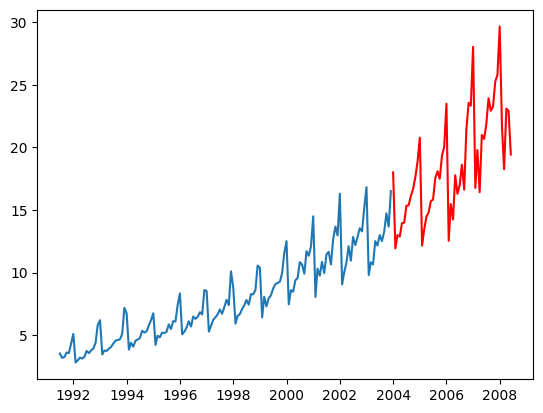

In [14]:
import matplotlib.pyplot as plt

plt.plot(data.index[:150], train)
plt.plot(data.index[150:], test, color='r')

## Modelo autoregresivo

El Modelo Autoregresivo (AR) es un tipo de modelo estadístico que predice valores futuros basados solo en los valores pasados. Se caracteriza por ser un modelo lineal, donde el valor actual se expresa como una suma de valores pasados multiplicados por un factor numérico.

**Estructura del Modelo AR**
El Modelo AR se denota como AR(p), donde “p” es el orden del modelo y representa el número de valores pasados que se incluyen en la predicción. La fórmula general es:
$$
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + \dots + \beta_p y_{t-p} + \epsilon

$$

Por lo tanto, tendremos que encontrar el orden de autoregression que mejor encaje con nuestros datos. Cuantos $p$ debemos tener en cuenta hacia atrás.

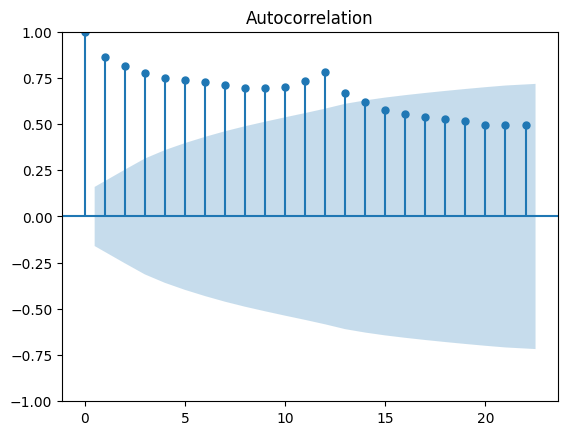

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(train);

In [16]:
from statsmodels.tsa.ar_model import AutoReg

# AR(1)
mod = AutoReg(train, 1)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                     AutoReg(1)   Log Likelihood                -274.183
Method:               Conditional MLE   S.D. of innovations              1.524
Date:                Wed, 24 Jul 2024   AIC                            554.366
Time:                        21:12:27   BIC                            563.378
Sample:                             1   HQIC                           558.028
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8206      0.321      2.557      0.011       0.192       1.450
y.L1           0.9058      0.038     23.868      0.000       0.831       0.980
                                    Roots           

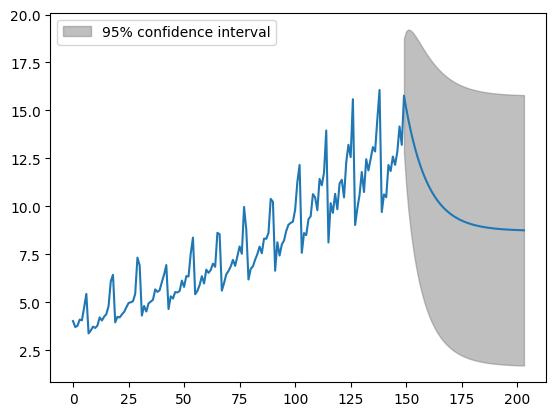

In [17]:
fig = res.plot_predict(1, len(data))

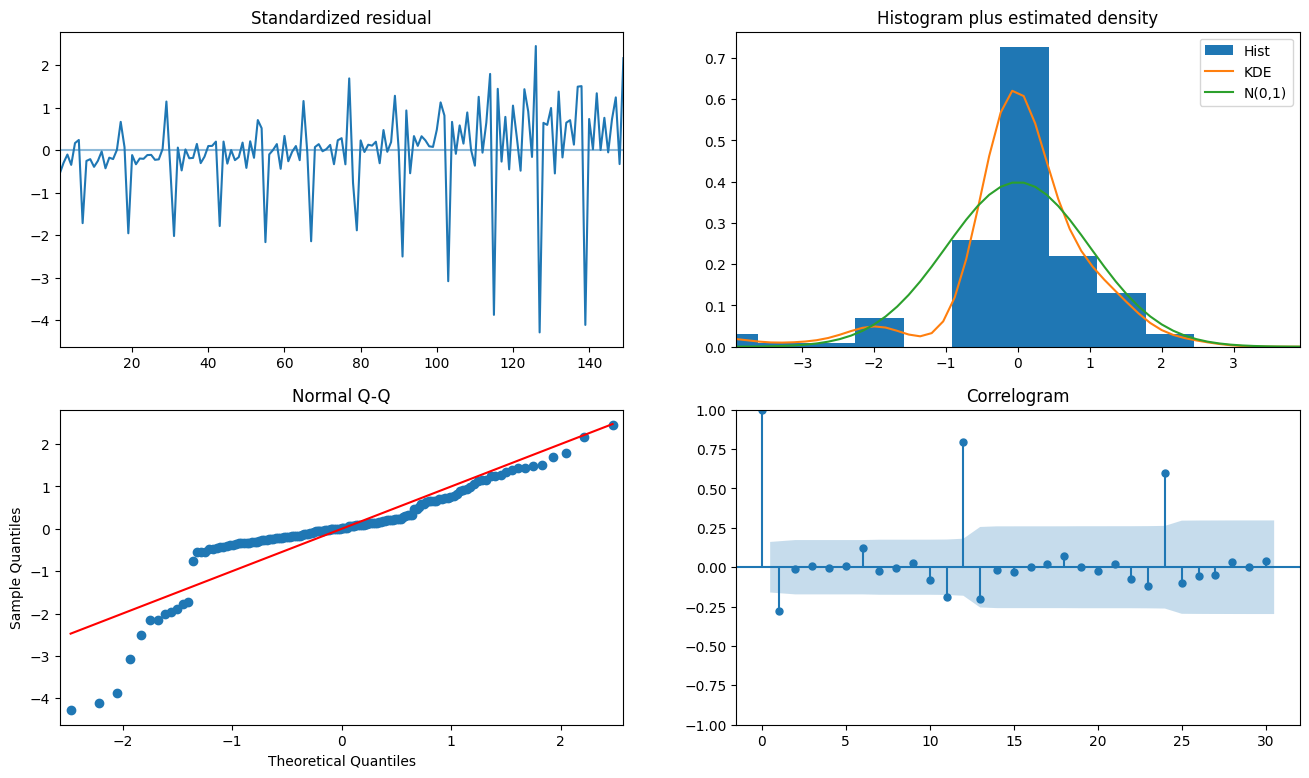

In [18]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

¿Qué vemos en el gráfico?

* Los residuos deberían mostrarse con media cero y varianza uniforme.
* El plot de densidad debería corresponder a una serie normal.
* Todos los puntos deberían caer en la línea roja, si no la distribución será asimétrica.
* No debería haber correlación entre los residuos, si no es que nos hemos dejado algo al modelar.

No parece que de buen resultado el AR(1). Probemos diferentes lags, a ver cuál sería el mejor

In [19]:
lag = int(input("Número de lags"))

mod = AutoReg(train, lag)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  150
Model:                    AutoReg(12)   Log Likelihood                -102.393
Method:               Conditional MLE   S.D. of innovations              0.508
Date:                Wed, 24 Jul 2024   AIC                            232.787
Time:                        21:12:33   BIC                            273.768
Sample:                            12   HQIC                           249.441
                                  150                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4656      0.126      3.695      0.000       0.219       0.713
y.L1           0.0304      0.035      0.874      0.382      -0.038       0.099
y.L2           0.0076      0.035      0.219      0.8

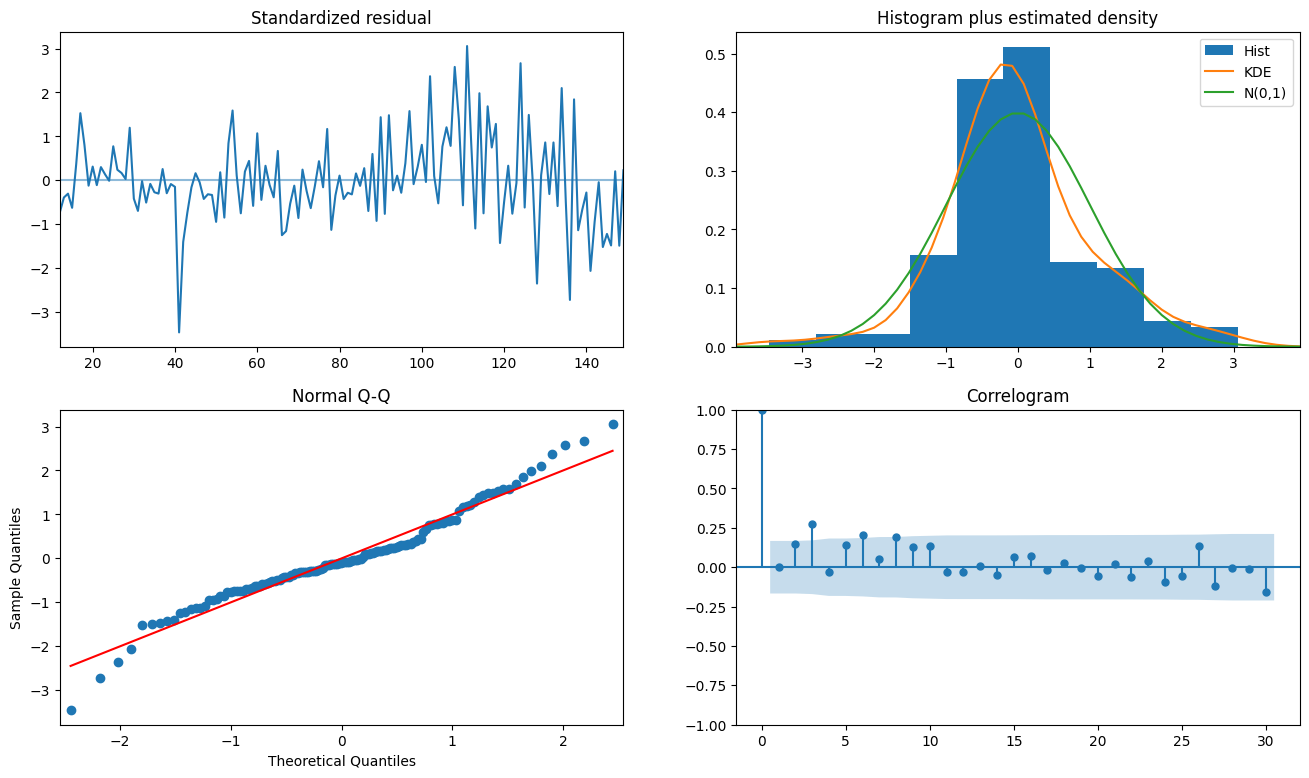

In [20]:
fig = plt.figure(figsize=(16, 9))
fig = res.plot_diagnostics(fig=fig, lags=30)

Un parámetro cercano a 12 parece que da buen resultado, pero aun asi es muy alto el error.

## Moving Average

La media móvil (MA) es un proceso en el que el valor actual de una serie temporal, y, se define como una combinación lineal de errores pasados. El término de error (ruido) se representa como $e$. Tanto $t-1$ como $t-2$ son retardos temporales de los errores.

MA(1) model: $y_{t}$ = $m_{1}$ $e_{t-1}$ + $e_{t}$

MA(2) model: $y_{t}$ = $m_{1}$ $e_{t-1}$ + $m_{2}$ $e_{t-2}$ + $e_{t}$

La media móvil nos puede ayudar a eliminar la componente de tendencia a la hora de hacer nuestras estimaciones.

In [21]:
train = train.reshape(-1)

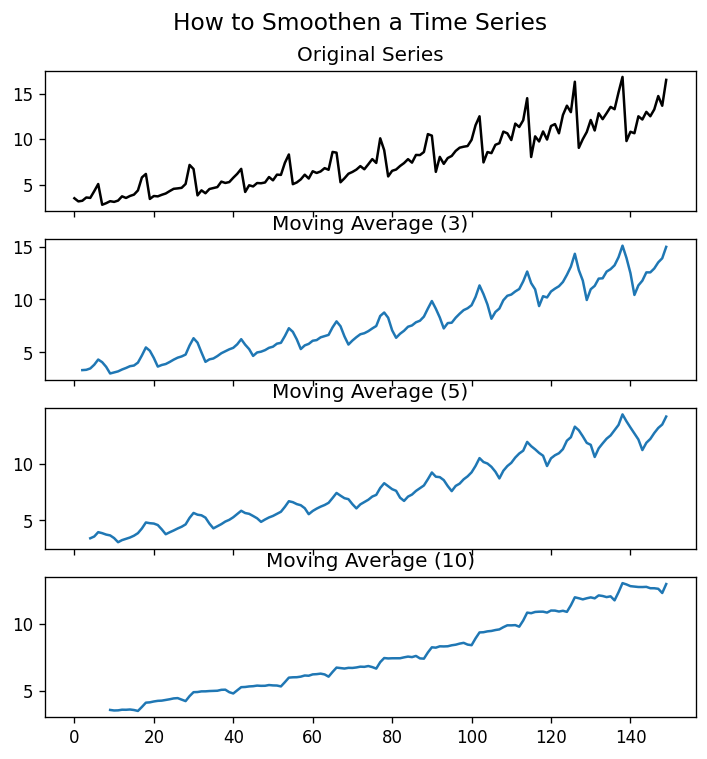

In [22]:
# Moving Average
df_ma = pd.Series(train).rolling(3).mean()
df_ma_5 = pd.Series(train).rolling(5).mean()
df_ma_10 = pd.Series(train).rolling(10).mean()

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
pd.Series(train).plot(ax=axes[0], color='k', title='Original Series')
df_ma.plot(ax=axes[1], title='Moving Average (3)')
df_ma_5.plot(ax=axes[2], title='Moving Average (5)')
df_ma_10.plot(ax=axes[3], title='Moving Average (10)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

Armado con nuestros dos modelos, podemos realizar un modelo ARMA que combina ambas técnicas en un único estimador.

In [23]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [24]:
import warnings

warnings.filterwarnings(action="ignore")

In [25]:
from pmdarima.arima import ARIMA

model_ma = ARIMA(order = (2,0,5))
model_ma.fit(train)

ARIMA(order=(2, 0, 5))

In [26]:
from sklearn.metrics import mean_squared_error

predictions = model_ma.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

mean_squared_error: 51.15457914756827


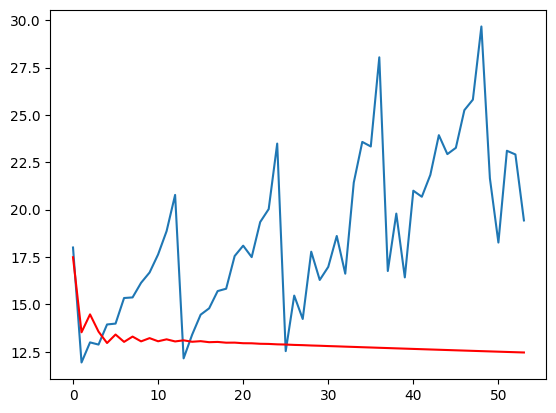

In [27]:
plt.plot(test)
plt.plot(predictions,color='red');

No está dando buen resultado. Probaremos entonces varios lags aunque el hecho de que la serie no sea estacionaria puede darnos problemas.

## ARIMA
En el arima no solo influyen los parámetros `p` y `q`, sino que también tendremos en cuenta `d`. Parametro con el que diferenciaremos la serie y conseguiremos que sea estacionaria.

In [ ]:
d = 1 # Cambiad d

diff = pd.Series(train)
for _ in range(d):
    diff = diff.diff()
plt.plot(diff)
plt.show()

In [ ]:
adfuller(diff.dropna())[1]

Ahora bien, ¿cuál es la mejor combinación de parámetros? Tendremos que realizar varias pruebas. Para comparar los modelos se suele utilizar el AIC.

#### ¿Cómo conseguir los mejores p, d, q?

In [ ]:
import itertools

p = range(0,5)
d = range(0,2)
q = range(0,5)
pdq = list(itertools.product(p,d,q))
pdq[:10]

In [ ]:
len(pdq)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

results = []
for param in pdq:
    try:
        model_arima = ARIMA(order=param)
        model_arima_fit = model_arima.fit(train)
        results.append((param,model_arima_fit.aic()))
    except:
        continue

In [ ]:
resultados_df = pd.DataFrame(results, columns=['ARIMA params', 'AIC']).sort_values('AIC')
resultados_df.head()

In [ ]:
len(resultados_df)

Ya tenemos la mejor combinación de parámetros para el ARIMA. Probemos el modelo

In [ ]:
best_model = ARIMA(order=(4,1,2))
best_model.fit(train)

In [ ]:
best_model.predict(14)

In [ ]:
predictions = best_model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

In [ ]:
plt.plot(test)
plt.plot(predictions,color='red');

### Auto ARIMA

Auto ARIMA nos permite incluir aspectos como valores máximos y mínimos para los parámetros base (p, q y d), si necesitamos incluir modelado estacional, número de periodos que cubre cada componente estacional, etc. Disponéis de toda la información en la documentación oficial: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html#pmdarima.arima.auto_arima 

In [ ]:
from pmdarima.arima import auto_arima

smodel = auto_arima(data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

In [ ]:
smodel

In [ ]:
smodel.summary()

In [ ]:
# Forecast
n_periods = 24
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

In [ ]:
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

In [ ]:
# Plot
plt.plot(data)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
plt.show()

## ARIMAX

La $X$ viene de exogenous. Significa que le podemos añadir una variable externa con la que entrenar el modelo.

Tomaremos los datos de mercado de Facebook para realizar un ejercicio con variables exógenas.

In [ ]:
data = pd.read_csv("data/FB.csv")
data

In [ ]:
data.Close.plot(figsize=(14, 7))

Vemos primero ejemplo sin variable exogena

In [ ]:
train = data.loc[:1200,'Close'].values
test = data.loc[1200:,'Close'].values

In [ ]:
len(test)

Vamos a probar varios SARIMA, a ver cuál sería la mejor combinación de hiperparámetros.

In [ ]:
stepwise_model = auto_arima(train,
                            start_p=1,
                            start_q=1,
                            max_d=10,
                            max_p=10,
                            max_q=10,
                            stationary=False,
                            trace=True,
                           stepwise=True)
print(stepwise_model.aic())

Ya lo tenemos, ahora montaremos el modelo con esos hiperparámetros y vemos que AIC tiene.

In [ ]:
model = ARIMA(order=(1,1,1))
model.fit(train)
print(model.summary())

In [ ]:
predictions = model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))

In [ ]:
plt.plot(test)
plt.plot(predictions,color='red');

Vamos ahora a compararlo con el mismo modelo, pero en este caso le añadimos una variable exogena al entrenamiento

In [ ]:
data.loc[:1200,['Close','Open']]

In [ ]:
model = ARIMA(order=(1,1,1))
model.fit(train, X = data.loc[:1200,['Open']])
print(model.summary())

Probemos a entrenar el auto arima con la variable exogena

In [ ]:
model = auto_arima(train,
                   X = data.loc[:1200,['Open']],
                   start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    trace=True,
                    stepwise=True)

print(model.aic())

In [ ]:
model = ARIMA(order=(1,0,1))
model.fit(train, X = data.loc[:1200,['Open']])
predictions = model.predict(len(test), X = data.loc[1200:,['Open']])

plt.plot(test)
plt.plot(range(len(test)), predictions.values, color='red');

Probemos varias variables exógenas

NOTA: para este apartado se utiliza el valor 'Low', que en la vida real no lo tendríamos para realizar la predicción.

In [ ]:
model = auto_arima(train,
                   X = data.loc[:1200,['Open',"Low"]],
                   start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    stationary=False,
                    trace=True,
                    stepwise=True)

print(model.aic())

In [ ]:
model.summary()

In [ ]:
model = ARIMA(order=(3,1,1))
model.fit(train, X = data.loc[:1200,['Open',"Low"]])
predictions = model.predict(len(test), X = data.loc[1200:,['Open',"Low"]])
print("mean_squared_error:", mean_squared_error(test, predictions))

In [ ]:
plt.plot(test)
plt.plot(range(len(test)), predictions.values, color='red');

## SARIMA
Veamos cómo podemos predecir con datos que tienen estacionalidad, es decir, que cuentan con un patrón que se repite a lo largo del tiempo.

In [ ]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

In [ ]:
df['value'].plot(figsize=(15,6));

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_add = seasonal_decompose(df[['value']], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (6,6)})
result_add.plot();

In [ ]:
X = df[['value']]
train = X[:-20]
test = X[-20:]

In [ ]:
len(test)

In [ ]:
plot_acf(train);

Probemos el auto arima sin indicarle que hay componente de seasonality

In [ ]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

Ahora le añadimos el componente seasonality mediante el parametro `m`.

In [ ]:
model = auto_arima(train,
                    start_p=1,
                    start_q=1,
                    max_d=3,
                    max_p=5,
                    max_q=5,
                    m = 12,
                    trace=True,
                    stepwise=True)

print(model.aic())

predictions = model.predict(20)
print("mean_squared_error:", mean_squared_error(test, predictions))

In [ ]:
predictions

In [ ]:
test.values

In [ ]:
test

In [ ]:
predictions = model.predict(len(test))
print("mean_squared_error:", mean_squared_error(test, predictions))
plt.plot(test)
plt.plot(predictions,color='red');

## Transformar dataset para poder predecir con otros modelos

In [ ]:
df = pd.read_csv('data/a10.csv', parse_dates=['date'], index_col='date')
print(len(df))
df.head()

In [ ]:
df['value'].shift(1)

In [ ]:
for i in range(12,0,-1):
    df['t-'+str(i)] = df['value'].shift(i)

df.dropna(inplace=True)
df

In [ ]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True)

Referencias:

* Hands on Time Series https://learning.oreilly.com/library/view/hands-on-time-series/9781484259924/
* Time Series con otros modelos https://learning.oreilly.com/videos/time-series-analysis/9781838640590/?autoplay=false
* Aquí cuenta bastante bien el tema de los parámetros ARIMA https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts
* Tutorial de ARIMA en vídeo https://www.youtube.com/watch?v=D9y6dcy0xK8
* Mas ARIMA con Python https://machinelearningmastery.com/make-sample-forecasts-arima-python/